Assignment 1: Predict diabetes using Perceptron
Student: Pujan Maharjan (a1863495)
Course: Deep Learning Fundamentals

In [41]:
# install required libraries
# !pip install ipywidgets
# !pip install seaborn
# !pip install ipywidgets


In [42]:
import torch
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
sns.set()


In [43]:
# Understand Data
# filename = "diabetes.txt"
filename = "diabetes_scale.txt"
X, y = load_svmlight_file(filename)
X = X.toarray()
# reshape y from (768,) to (768,1)
y = y.reshape(-1, 1)
print('X : ', X.shape)
print('Y : ', y.shape)
all_data = np.append(X, y, axis=1)
print('all_data Shape ', all_data.shape)
columns = ['Pregnancies', 'Glucose', 'Blood Pressure', 'Skin Thickness', 'Insulin', 'BMI', 'Diabetes Pedigree', 'Age', 'Output']
df = pd.DataFrame(all_data, columns=columns)
df

X :  (768, 8)
Y :  (768, 1)
all_data Shape  (768, 9)


,Pregnancies,Glucose,Blood Pressure,Skin Thickness,Insulin,BMI,Diabetes Pedigree,Age,Output
0,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333,-1.0
1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667,1.0
2,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333,-1.0
3,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000,1.0
4,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000,-1.0
...,...,...,...,...,...,...,...,...,...
763,0.176471,0.015075,0.245902,-0.030303,-0.574468,-0.019374,-0.920581,0.400000,1.0
764,-0.764706,0.226131,0.147541,-0.454545,-1.000000,0.096870,-0.776260,-0.800000,1.0
765,-0.411765,0.216080,0.180328,-0.535354,-0.735225,-0.219076,-0.857387,-0.700000,1.0
766,-0.882353,0.266332,-0.016393,-1.000000,-1.000000,-0.102832,-0.768574,-0.133333,-1.0


In [44]:
desc_data = df.describe().T
desc_data

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,-0.547641,0.396421,-1.0,-0.882353,-0.647059,-0.294118,1.0
Glucose,768.0,0.215020,0.321333,-1.0,-0.005025,0.175879,0.409547,1.0
Blood Pressure,768.0,0.132877,0.317308,-1.0,0.016393,0.180328,0.311475,1.0
Skin Thickness,768.0,-0.585122,0.322267,-1.0,-1.000000,-0.535354,-0.353535,1.0
Insulin,768.0,-0.811349,0.272444,-1.0,-1.000000,-0.927896,-0.699173,1.0
BMI,768.0,-0.046421,0.234997,-1.0,-0.186289,-0.046200,0.090909,1.0
Diabetes Pedigree,768.0,-0.663641,0.282945,-1.0,-0.858455,-0.748506,-0.531811,1.0
Age,768.0,-0.591971,0.392008,-1.0,-0.900000,-0.733333,-0.333333,1.0
Output,768.0,0.302083,0.953903,-1.0,-1.000000,1.000000,1.000000,1.0


In [45]:
desc_data[["mean", "std", "min", "max"]]

,mean,std,min,max
Pregnancies,-0.547641,0.396421,-1.0,1.0
Glucose,0.215020,0.321333,-1.0,1.0
Blood Pressure,0.132877,0.317308,-1.0,1.0
Skin Thickness,-0.585122,0.322267,-1.0,1.0
Insulin,-0.811349,0.272444,-1.0,1.0
BMI,-0.046421,0.234997,-1.0,1.0
Diabetes Pedigree,-0.663641,0.282945,-1.0,1.0
Age,-0.591971,0.392008,-1.0,1.0
Output,0.302083,0.953903,-1.0,1.0


In [46]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pregnancies        768 non-null    float64
 1   Glucose            768 non-null    float64
 2   Blood Pressure     768 non-null    float64
 3   Skin Thickness     768 non-null    float64
 4   Insulin            768 non-null    float64
 5   BMI                768 non-null    float64
 6   Diabetes Pedigree  768 non-null    float64
 7   Age                768 non-null    float64
 8   Output             768 non-null    float64
dtypes: float64(9)
memory usage: 54.1 KB


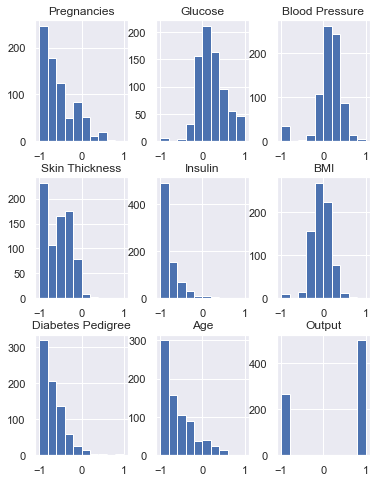

In [47]:
histogram = df.hist(figsize=(6,8))

In [48]:
print(df['Output'].value_counts())

 1.0    500
-1.0    268
Name: Output, dtype: int64


In [49]:
class PerceptronCustom():
    def __init__(self, 
        file_path, 
        weights, 
        loss_function_name, 
        learning_rate, 
        epoch,
        add_bias = False) -> None:
        self.file_path = file_path
        self.weights = weights
        self.loss_function_name = loss_function_name
        self.learning_rate = learning_rate
        self.epoch = epoch
        self.add_bias = add_bias
        self.train_data = None
        self.epochs = []
        self.train_losses = []
        self.validation_losses = []        
        self.train_accuracies = []
        self.validation_accuracies = []
        self.train_validation_y_labels = ['Train', 'Validation']

    def get_features_labels_from_file_data(self):
        X, y = load_svmlight_file(self.file_path)
        # convert X from scipy.sparce.csr.csr_matrix to numpy array
        X = X.toarray()
        # reshape y from (768,) to (768,1)
        y = y.reshape(-1, 1)
        return X,y

    def predict(self, X):
        np_sign_values = np.sign(np.dot(X, self.weights))
        # numpy sign function returns -1, 0, 1,
        # thus for 1 and 0, return 1
        predictions_list = []
        for np_sign_value in np_sign_values:
            if np_sign_value >= 0:
                predictions_list.append(1)
            else:
                predictions_list.append(-1)

        return np.array(predictions_list).reshape(-1,1)

    def zero_one_loss(self, X, y):
        # print('zero one loss X ', X.shape, ', w , ',self.weights.shape)
        xw = np.dot(X, self.weights)
        losses = []
        # if correct prediction, then loss = 0, else loss = 1
        for i in range(len(y)):
            indicator = y[i] * xw[i]
            if indicator < 0:
                losses.append(1)
            else:
                losses.append(0)

        return np.array(losses).reshape(-1,1)

    def perceptron_loss(self, X, y):        
        x_w = np.dot(X, self.weights)
        p_loss_mat = y * x_w
        
        perceptron_loss_values = []
        for num in p_loss_mat:
            num_value = num[0]
            max_val = max(0, -num_value)
            perceptron_loss_values.append(max_val)

        return np.array(perceptron_loss_values).reshape(-1,1)

    def hinge_loss(self, X, y):        
        x_w = np.dot(X, self.weights)
        hinge_loss_mat = y * x_w
        
        hinge_loss_values = []
        for num in hinge_loss_mat:
            num_value = num[0]
            max_val = max(0, 1 - num_value)
            hinge_loss_values.append(max_val)

        return np.array(hinge_loss_values).reshape(-1,1)

    def normal_loss(self, X, y):
        normal_loss_values = self.predict(X) - y
        return normal_loss_values

    def l1_loss(self, X, y):
        return abs(self.normal_loss(X,y))

    def add_bias_in_features(self, X_for_bias):
        bias_X = np.ones((X_for_bias.shape[0],1))
        X_for_bias = np.append(bias_X, X_for_bias, axis=1)
        return X_for_bias
        
    def train(self, X_train, y_train, X_val, y_val):
        train_data = []
        if self.add_bias:
            X_train = self.add_bias_in_features(X_train)
            X_val = self.add_bias_in_features(X_val)
            bias_value = np.random.uniform(low=-.1,high=.1, size=1)
            # print('Bias Value ', bias_value)
            bias_W = np.array([bias_value])
            self.weights = np.append(bias_W, self.weights, axis=0)
            
        for epoch_number in range(self.epoch):
            train_loss = None
            validation_loss = None
            train_accuracy = None
          
            if (self.loss_function_name == "zero_one_loss"):
                train_loss = self.zero_one_loss(X_train, y_train)
                validation_loss = self.zero_one_loss(X_val, y_val)  
                                                                         
            elif self.loss_function_name == "perceptron_loss":
                train_loss = self.perceptron_loss(X_train, y_train)
                validation_loss = self.perceptron_loss(X_val, y_val)

            elif self.loss_function_name == "l1_loss":
                train_loss = self.l1_loss(X_train, y_train)
                validation_loss = self.l1_loss(X_val, y_val)

            elif self.loss_function_name == "hinge_loss":
                train_loss = self.hinge_loss(X_train, y_train)
                validation_loss = self.hinge_loss(X_val, y_val)

            else:
                raise "Loss function error " + self.loss_function_name
                
            yxlr = self.learning_rate * y_train * X_train * train_loss
            yxlr_sum = np.sum(yxlr, axis=0).reshape(-1,1)                
            self.weights = self.weights + yxlr_sum

            train_accuracy = self.accuracy(X_train, y_train)
            validation_accuracy = self.accuracy(X_val, y_val)
            train_loss_sum = np.sum(train_loss) / X_train.shape[0]
            validation_loss_sum = np.sum(validation_loss) / X_val.shape[0]

            # print('Epoch ', epoch_number, ', Val accuracy: ', validation_accuracy, ', Val loss: ', validation_loss_sum)
            self.epochs.append(epoch_number)
            self.train_losses.append(train_loss_sum)
            self.validation_losses.append(validation_loss_sum)
            self.train_accuracies.append(train_accuracy)
            self.validation_accuracies.append(validation_accuracy)
            train_data.append({
                'learning_rate': self.learning_rate, 
                'epoch': epoch_number, 
                'train_loss': train_loss_sum, 
                'val_loss': validation_loss_sum,
                'val_accuracy': validation_accuracy,
                'train_accuracy': train_accuracy})

        # print('Training Completed')
        self.train_data = train_data
        return train_data

    def accuracy(self, X_accuracy, y_accuracy):
        predictions_for_accuracy = self.predict(X_accuracy)
        accuracy_score_from_sk_learn = accuracy_score(y_accuracy, predictions_for_accuracy)
        return accuracy_score_from_sk_learn

    def split_train_validation_test(self, X, y, test_split_percentage):
        # reference to split (train/validation/test):
        #  https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
        # print('test_split_percentage ', test_split_percentage)
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
            test_size=test_split_percentage, 
            random_state=1, 
            shuffle=True,
            # stratify=y
            )
        # 0.25 * 0.8 = 0.2
        val_split_percentage = test_split_percentage / (1 - test_split_percentage)
        # print('val_split_percentage ', val_split_percentage)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
            test_size=val_split_percentage, 
            random_state=1, 
            shuffle=True,
            # stratify=y_train
            )

        # print('Train: ', X_train.shape[0], ', Val: ', X_val.shape[0], ', Test: ', X_test.shape[0])
        return X_train, X_val, X_test, y_train, y_val, y_test

    def plot_line_graphs(self, x_values, y_values_list, y_labels, title, ylabel):
        for y_values, y_label in zip(y_values_list, y_labels):
            plt.plot(x_values, y_values, label = y_label)

        plt.legend()
        plt.title(title)
        plt.xlabel("Epochs")
        plt.ylabel(ylabel)
        plt.show()

    def plot_loss_curves(self, title_suffix):        
        y_values_list = [self.train_losses, self.validation_losses]
        self.plot_line_graphs(self.epochs, y_values_list, self.train_validation_y_labels, 'Loss vs Epoch ' + title_suffix, 'Loss')

    def plot_accuracy_curves(self, title_suffix):
        y_values_list = [self.train_accuracies, self.validation_accuracies]
        self.plot_line_graphs(self.epochs, y_values_list, self.train_validation_y_labels, 'Accuracy vs Epoch ' + title_suffix, 'Accuracy')



In [50]:
# Test
# 1. Input Size, split sizes
split_sizes = [.1,.15,.2]
# 2. Weight Random seed
random_seeds = [0, 100, 200]
# 3. Weight distribution
weight_distributions = ["random", "normal", "ones"]
# 4. bias
add_bias_list = [False, True]
# 5. loss functions
loss_functions = ['zero_one_loss', 'perceptron_loss', 'l1_loss', 'hinge_loss']
# 6. Learning rate
learning_rates = [1,0.1,0.001,0.0001]
# 7. Epoch
epochs = [10,20,30,40,50,100]
default_file_path = 'diabetes_scale.txt'
def train_model(weight_distribution, loss_function_name, learning_rate, epoch, split_size,
    add_bias, plot_graph = False):
    np.random.seed(random_seed)
    weights = None
    if weight_distribution == "random":
        weights = np.random.rand(8).reshape(-1,1)
    elif weight_distribution == "normal":
        weights = np.random.normal(size=(8,1))
    elif weight_distribution == "ones":
        weights = np.ones(8).reshape(-1,1)
    
    perceptron = PerceptronCustom( 
        file_path=default_file_path,
        weights=weights, 
        loss_function_name=loss_function_name, 
        learning_rate=learning_rate, 
        epoch=epoch,
        add_bias=add_bias)
    X, y = perceptron.get_features_labels_from_file_data()
    X_train, X_val, X_test, y_train, y_val, y_test = perceptron.split_train_validation_test(
        X, y, split_size)
    train_data = perceptron.train(X_train, y_train, X_val, y_val)
    if plot_graph:
        perceptron.plot_loss_curves(default_file_path)
        perceptron.plot_accuracy_curves(default_file_path)
    # print('train data ', train_data)
    last_train_data = [td for td in train_data if td['epoch'] == epoch - 1][0]
    
    return {
            'split_size': split_size,
            'random_seed': random_seed,
            'weight_distribution': weight_distribution,
            'add_bias': add_bias,
            'learning_rate': learning_rate,
            'epoch': epoch,
            'train_accuracy': last_train_data['train_accuracy'],
            'val_accuracy': last_train_data['val_accuracy'],
            'train_loss': last_train_data['train_loss'],
            'val_loss': last_train_data['val_loss'],
            'loss_function_name': loss_function_name
            }

counter = 0
results = []
for split_size in split_sizes:
    for random_seed in random_seeds:
        for weight_distribution in weight_distributions:
            for add_bias in add_bias_list:
                for loss_function_name in loss_functions:
                    for learning_rate in learning_rates:
                        for epoch in epochs:
                            counter += 1
                            # print('counter = ', counter)
                            # Experiment
                            result = train_model(
                                weight_distribution, 
                                loss_function_name, 
                                learning_rate, 
                                epoch, 
                                split_size,
                                add_bias)

                            results.append(result)

print('Training completed')


                        
                

Training completed


In [51]:
results_df = pd.DataFrame(results)
results_df

,split_size,random_seed,weight_distribution,add_bias,learning_rate,epoch,train_accuracy,val_accuracy,train_loss,val_loss,loss_function_name
0,0.1,0,random,False,1.0000,10,0.723127,0.779221,0.355049,0.246753,zero_one_loss
1,0.1,0,random,False,1.0000,20,0.755700,0.727273,0.241042,0.220779,zero_one_loss
2,0.1,0,random,False,1.0000,30,0.654723,0.506494,0.252443,0.207792,zero_one_loss
3,0.1,0,random,False,1.0000,40,0.680782,0.623377,0.319218,0.220779,zero_one_loss
4,0.1,0,random,False,1.0000,50,0.635179,0.493506,0.283388,0.220779,zero_one_loss
...,...,...,...,...,...,...,...,...,...,...,...
5179,0.2,200,ones,True,0.0001,20,0.395652,0.435065,1.214818,1.148318,hinge_loss
5180,0.2,200,ones,True,0.0001,30,0.460870,0.480519,1.131742,1.070518,hinge_loss
5181,0.2,200,ones,True,0.0001,40,0.506522,0.532468,1.089030,1.030754,hinge_loss
5182,0.2,200,ones,True,0.0001,50,0.536957,0.545455,1.056778,1.001458,hinge_loss


In [52]:

# top 3 records
redf = results_df.sort_values(by=["val_accuracy", "val_loss"], ascending=[False,True])[0:3]
redf.T

,111,86,759
split_size,0.1,0.1,0.1
random_seed,0,0,100
weight_distribution,random,random,random
add_bias,True,False,True
learning_rate,0.001,0.001,0.001
epoch,40,30,40
train_accuracy,0.765472,0.758958,0.765472
val_accuracy,0.857143,0.857143,0.844156
train_loss,0.249186,0.694733,0.654523
val_loss,0.285714,0.685359,0.63689


In [53]:
optimal_record_df = redf.iloc[0]
optimal_parameters = optimal_record_df.to_dict()
optimal_parameters

{'split_size': 0.1,
 'random_seed': 0,
 'weight_distribution': 'random',
 'add_bias': True,
 'learning_rate': 0.001,
 'epoch': 40,
 'train_accuracy': 0.7654723127035831,
 'val_accuracy': 0.8571428571428571,
 'train_loss': 0.249185667752443,
 'val_loss': 0.2857142857142857,
 'loss_function_name': 'zero_one_loss'}

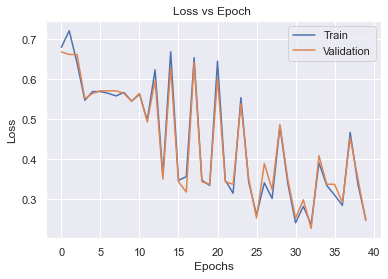

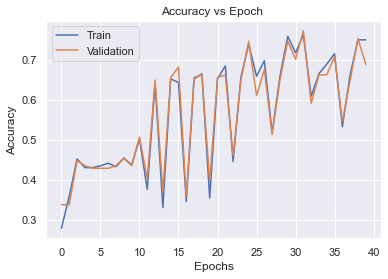

Test accuracy  0.7727272727272727


In [54]:
# get test accuracy for these top 1  parameters
# from result top 1, one with low validation loss

# weight distribution type is random

np.random.seed(optimal_parameters['random_seed'])
weights = np.random.rand(8).reshape(-1,1)
perceptron = PerceptronCustom( 
    file_path=default_file_path,
    weights=weights, 
    loss_function_name=optimal_parameters['loss_function_name'], 
    learning_rate=optimal_parameters['learning_rate'], 
    epoch=optimal_parameters['epoch'],
    add_bias=optimal_parameters['add_bias'])
X, y = perceptron.get_features_labels_from_file_data()
X_train, X_val, X_test, y_train, y_val, y_test = perceptron.split_train_validation_test(
        X, y, .2)
train_data = perceptron.train(X_train, y_train, X_val, y_val)
perceptron.plot_loss_curves('')
perceptron.plot_accuracy_curves('')

X_test = perceptron.add_bias_in_features(X_test)
test_accuracy = perceptron.accuracy(X_test, y_test)
print('Test accuracy ', test_accuracy)

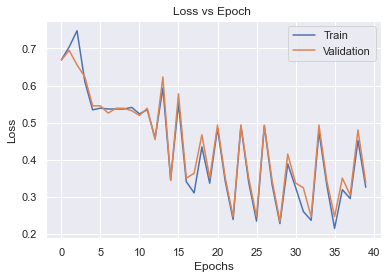

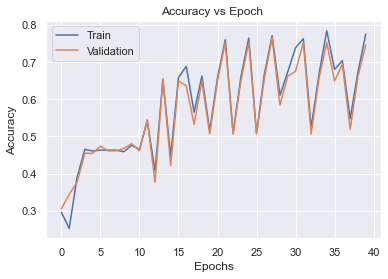

Test accuracy  0.7727272727272727


In [55]:
# get test accuracy for these top 1  parameters
# from result top 1, one with low validation loss

# weight distribution type is random

np.random.seed(optimal_parameters['random_seed'])
weights = np.random.rand(8).reshape(-1,1)
perceptron = PerceptronCustom( 
    file_path=default_file_path,
    weights=weights, 
    loss_function_name=optimal_parameters['loss_function_name'], 
    learning_rate=optimal_parameters['learning_rate'], 
    epoch=optimal_parameters['epoch'],
    add_bias=False)
X, y = perceptron.get_features_labels_from_file_data()
X_train, X_val, X_test, y_train, y_val, y_test = perceptron.split_train_validation_test(
        X, y, .2)
train_data = perceptron.train(X_train, y_train, X_val, y_val)
perceptron.plot_loss_curves('')
perceptron.plot_accuracy_curves('')

# X_test = perceptron.add_bias_in_features(X_test)
test_accuracy = perceptron.accuracy(X_test, y_test)
print('Test accuracy ', test_accuracy)

In [56]:
from sklearn.metrics import precision_recall_fscore_support

y_test_pred = perceptron.predict(X_test)
precision, recall, fbeta_score, support = precision_recall_fscore_support(
    y_test, 
    y_test_pred,
    average="binary")
print(' Precision: ', precision, ', Recall: ', recall, ', F-score: ', fbeta_score)

 Precision:  0.7909090909090909 , Recall:  0.8787878787878788 , F-score:  0.8325358851674641


In [57]:
# precision recall curve
# ROC curve
# confusion matrix

from sklearn.metrics import precision_recall_curve, auc

precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_pred)
print('precisions ', len(precisions), ', ', precisions)

print('recalls ', len(recalls), ', ', recalls)

print('thresholds ', len(thresholds), ', ', thresholds)

auc_val = auc(recalls, precisions)
print('auc val ', auc_val)


precisions  3 ,  [0.64285714 0.79090909 1.        ]
recalls  3 ,  [1.         0.87878788 0.        ]
thresholds  2 ,  [-1  1]
auc val  0.8738095238095238


In [58]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print('fpr ', fpr)
print('tpr ', tpr)

fpr  [0.         0.41818182 1.        ]
tpr  [0.         0.87878788 1.        ]


In [59]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred).ravel()
print('Confusion matrix ', cm)
true_negative, false_positive, false_negative, true_positive = cm

print('True positive ', true_positive, 
    ', False positive ', false_positive, 
    ', False negative ', false_negative,
    ', True negative ', true_negative)


Confusion matrix  [32 23 12 87]
True positive  87 , False positive  23 , False negative  12 , True negative  32


In [60]:
c = confusion_matrix(y_test, y_test_pred)
print(c)

[[32 23]
 [12 87]]


In [61]:
# compare with Perceptron implementation from scikit learn
# import sklearn as sk

from sklearn.linear_model import Perceptron

filename = "diabetes_scale.txt"
X_sk, y_sk = load_svmlight_file(filename)
X_sk = X_sk.toarray()

X_train_sk, X_test_sk, y_train_sk, y_test_sk = train_test_split(X_sk, y_sk, 
            test_size=0.1, 
            random_state=1, 
            shuffle=True)

sklearn_perceptron = Perceptron()
sklearn_perceptron.fit(X_train_sk, y_train_sk)

accuracy_score_sklearn = sklearn_perceptron.score(X_test_sk, y_test_sk)
print('Accuracy score sklearn ', accuracy_score_sklearn)

y_test_predict_sk = sklearn_perceptron.predict(X_test_sk)
precision_sk, recall_sk, fbeta_score_sk, support_sk = precision_recall_fscore_support(
    y_test_sk, 
    y_test_predict_sk,
    average="binary")
print('Precision: ', precision_sk, ', Recall: ', recall_sk, ', F-score: ', fbeta_score_sk)

Accuracy score sklearn  0.7402597402597403
Precision:  0.7592592592592593 , Recall:  0.8541666666666666 , F-score:  0.8039215686274509


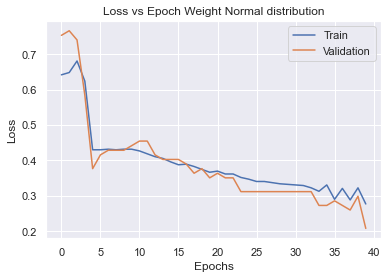

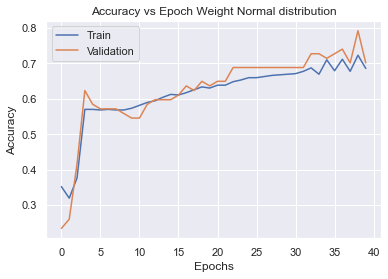

Test accuracy  0.7012987012987013


In [62]:

# Experiments 1. Weights
# 1.1 Normal distribution Weight
np.random.seed(optimal_parameters['random_seed'])
weights = np.random.normal(size=(8,1))
perceptron = PerceptronCustom( 
    file_path=default_file_path,
    weights=weights, 
    loss_function_name=optimal_parameters['loss_function_name'], 
    learning_rate=optimal_parameters['learning_rate'], 
    epoch=optimal_parameters['epoch'],
    add_bias=optimal_parameters['add_bias'])
X, y = perceptron.get_features_labels_from_file_data()
X_train, X_val, X_test, y_train, y_val, y_test = perceptron.split_train_validation_test(
        X, y, .1)
train_data = perceptron.train(X_train, y_train, X_val, y_val)
perceptron.plot_loss_curves('Weight Normal distribution')
perceptron.plot_accuracy_curves('Weight Normal distribution')

X_test = perceptron.add_bias_in_features(X_test)
test_accuracy = perceptron.accuracy(X_test, y_test)
print('Test accuracy ', test_accuracy)

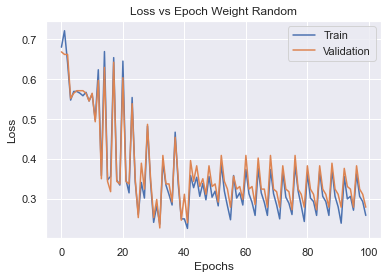

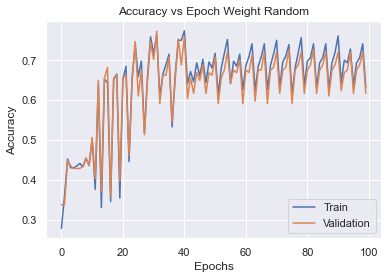

Test accuracy  0.6233766233766234


In [63]:

# Experiments 1. Weights
# 1.2 Random Weight
np.random.seed(optimal_parameters['random_seed'])
weights = np.random.rand(8).reshape(-1,1)
perceptron = PerceptronCustom( 
    file_path=default_file_path,
    weights=weights, 
    loss_function_name=optimal_parameters['loss_function_name'], 
    learning_rate=optimal_parameters['learning_rate'], 
    epoch=100,#optimal_parameters['epoch'],
    add_bias=optimal_parameters['add_bias'])
X, y = perceptron.get_features_labels_from_file_data()
X_train, X_val, X_test, y_train, y_val, y_test = perceptron.split_train_validation_test(
        X, y, .2)
train_data = perceptron.train(X_train, y_train, X_val, y_val)
perceptron.plot_loss_curves('Weight Random')
perceptron.plot_accuracy_curves('Weight Random')

X_test = perceptron.add_bias_in_features(X_test)
test_accuracy = perceptron.accuracy(X_test, y_test)
print('Test accuracy ', test_accuracy)

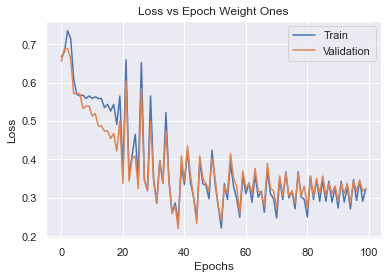

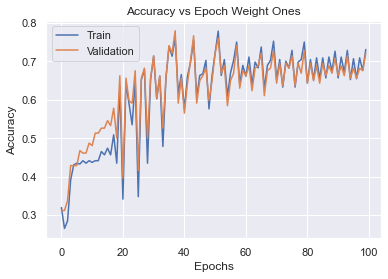

Test accuracy  0.7272727272727273


In [64]:

# Experiments 1. Weights
# 1.3 Ones weight
np.random.seed(optimal_parameters['random_seed'])
weights = np.ones(8).reshape(-1,1)
perceptron = PerceptronCustom( 
    file_path=default_file_path,
    weights=weights, 
    loss_function_name=optimal_parameters['loss_function_name'], 
    learning_rate=optimal_parameters['learning_rate'], 
    epoch=100,#optimal_parameters['epoch'],
    add_bias=optimal_parameters['add_bias'])
X, y = perceptron.get_features_labels_from_file_data()
X_train, X_val, X_test, y_train, y_val, y_test = perceptron.split_train_validation_test(
        X, y, .2)
train_data = perceptron.train(X_train, y_train, X_val, y_val)
perceptron.plot_loss_curves('Weight Ones')
perceptron.plot_accuracy_curves('Weight Ones')

X_test = perceptron.add_bias_in_features(X_test)
test_accuracy = perceptron.accuracy(X_test, y_test)
print('Test accuracy ', test_accuracy)

New X shape  (768, 100)


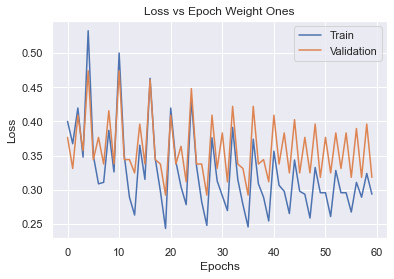

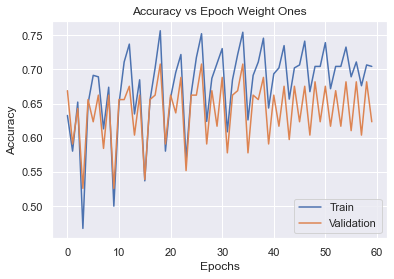

Test accuracy  0.6688311688311688


In [65]:

# Experiments 
# Kernel
from sklearn.kernel_approximation import RBFSampler

weights = np.ones(100).reshape(-1,1)
perceptron = PerceptronCustom( 
    file_path=default_file_path,
    weights=weights, 
    loss_function_name=optimal_parameters['loss_function_name'], 
    learning_rate=0.01,#optimal_parameters['learning_rate'], 
    epoch=60,#optimal_parameters['epoch'],
    add_bias=optimal_parameters['add_bias'])
X, y = perceptron.get_features_labels_from_file_data()
rbf = RBFSampler(gamma=1, random_state=1)
X = rbf.fit_transform(X)
np.random.seed(optimal_parameters['random_seed'])
print('New X shape ', X.shape)

X_train, X_val, X_test, y_train, y_val, y_test = perceptron.split_train_validation_test(
        X, y, .2)
train_data = perceptron.train(X_train, y_train, X_val, y_val)
perceptron.plot_loss_curves('Weight Ones')
perceptron.plot_accuracy_curves('Weight Ones')

X_test = perceptron.add_bias_in_features(X_test)
test_accuracy = perceptron.accuracy(X_test, y_test)
print('Test accuracy ', test_accuracy)

In [66]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_test_pred, target_names=["Yes", "No"])
print(report)

              precision    recall  f1-score   support

         Yes       0.73      0.58      0.65        55
          No       0.79      0.88      0.83        99

    accuracy                           0.77       154
   macro avg       0.76      0.73      0.74       154
weighted avg       0.77      0.77      0.77       154

